** This notebook was tested on Amazon EC2 G6e Instance (NVIDIA L40S Tensor Core GPU)

In [1]:
from demo_utils import *
# This code requires a Hugging Face token with Bria access
import os

# Welcome to Bria: AI-Powered Visual Content Generation

Bria is a visul-Gen-AI platform for builders, designed for commercial use and powered exclusively by licensed data.

Bria offers API & source-code models for safe and predictable visual Gen-AI development.

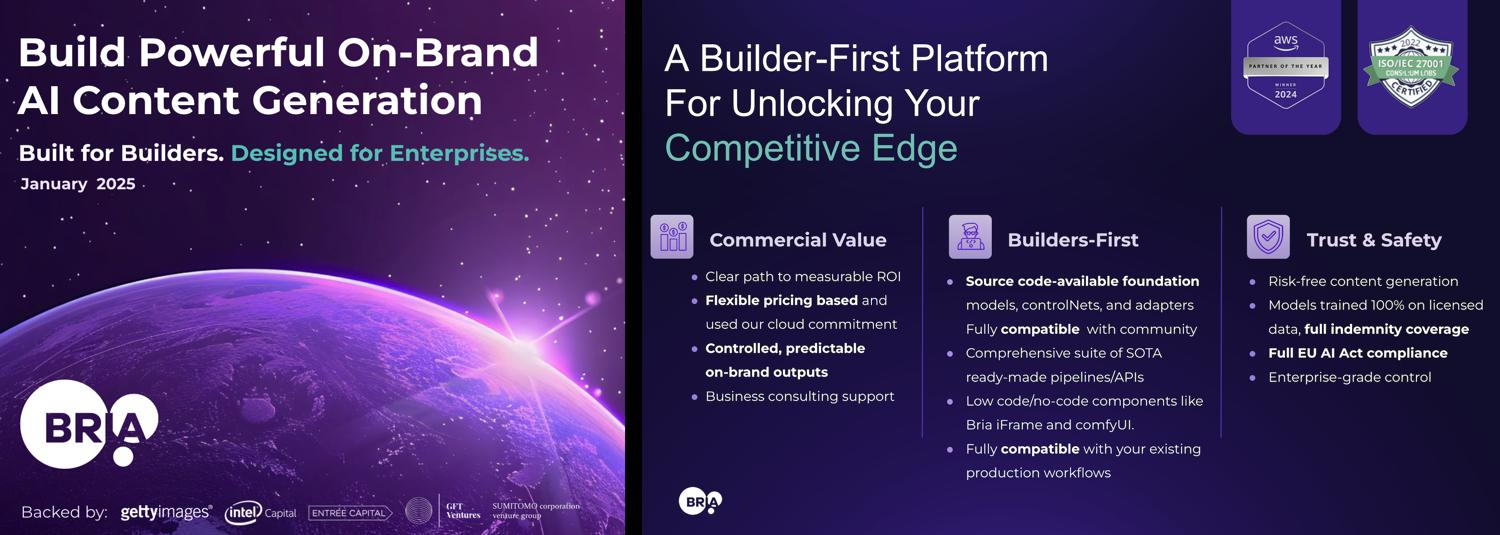

In [2]:
display_images([Image.open("./visuals/bria_intro.png")], resize = 1500)

This demo will showcase how developers can leverage Bria's **source-available** models **on-prem** to build tools that enable their users to generate and modify brand-consistent visuals at scale.

## Leveraging Gen-AI for Brand Content Creation

We'll use **Bria's models**, accesible through **Hugging Face**, to show how a developer can easily **build** tools for creating and editing **controlled**, **on-brand** visuals **at scale**.

A strong brand identity includes visual features such as:

- **Color Palette**
- **Style & Mood**
- **Recurring Characters ("mascot") & Themes** 
- **Fonts** 
- **Logo**

The example below showcases how such features are present in the Bria brand:

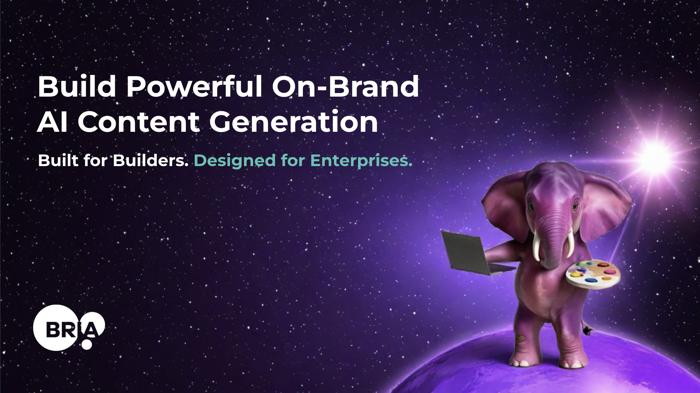

In [3]:
display_images([Image.open("./visuals/bria_brand_example.png")], resize=700)

## **Text-to-Image**: AI-Generated Visuals




Visual GenAI starts with text-to-image generation. 

Below, we define a function to generate images from a prompt using Bria-2.3 foundation text-to-image model by using the model weights available on HF: https://huggingface.co/briaai/BRIA-2.3

We'll start with a basic Text-to-Image (t2i) diffusers pipeline.

(Also available through API: https://docs.bria.ai/image-generation/endpoints/text-to-image)

In [3]:
from diffusers import DiffusionPipeline
import torch

t2i_pipe = DiffusionPipeline.from_pretrained("briaai/BRIA-2.3", torch_dtype=torch.float16, use_safetensors=True)
t2i_pipe.force_zeros_for_empty_prompt = False
t2i_pipe.to("cuda")

def text_to_image(prompt, num_results=3, seed=42):
    negative_prompt = "Logo,Watermark,Text,Ugly,Morbid,Extra fingers,Poorly drawn hands,Mutation,Blurry,Extra limbs,Gross proportions,Missing arms,Mutated hands,Long neck,Duplicate,Mutilated,Mutilated hands,Poorly drawn face,Deformed,Bad anatomy,Cloned face,Malformed limbs,Missing legs,Too many fingers"

    images = []
    for i in range(num_results):
        generator = torch.Generator(device="cuda:0").manual_seed(seed+i) 
        image = t2i_pipe(prompt=prompt, negative_prompt=negative_prompt, height=1024, width=1024, generator=generator, num_inference_steps=30).images[0]
        images.append(image)
    return images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

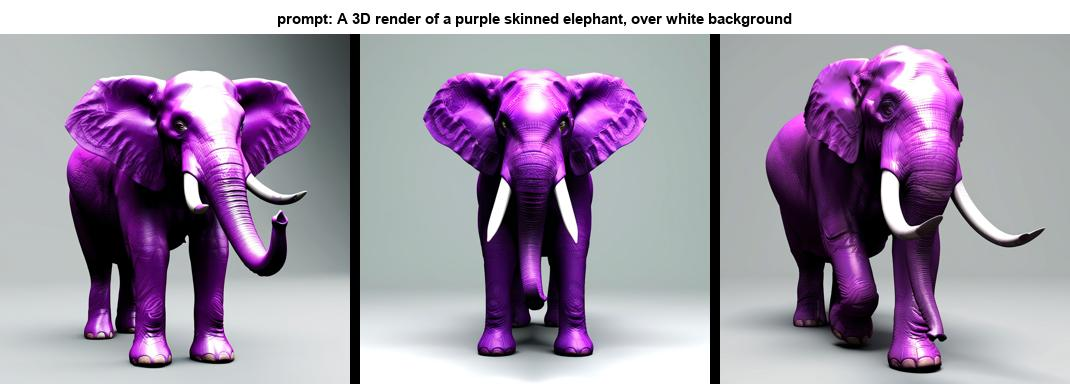

In [5]:
## Example: Generating an Image with Bria
# The following example demonstrates how Bria's API generates AI-driven visuals from text descriptions.

prompt = 'A 3D render of a purple skinned elephant, over white background'

images = text_to_image(prompt, num_results=3)
display_images(images, f"prompt: {prompt}")

**Bria’s Responsible AI**

Bria ensures content safety by preventing the generation of copyrighted material. For example: 

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

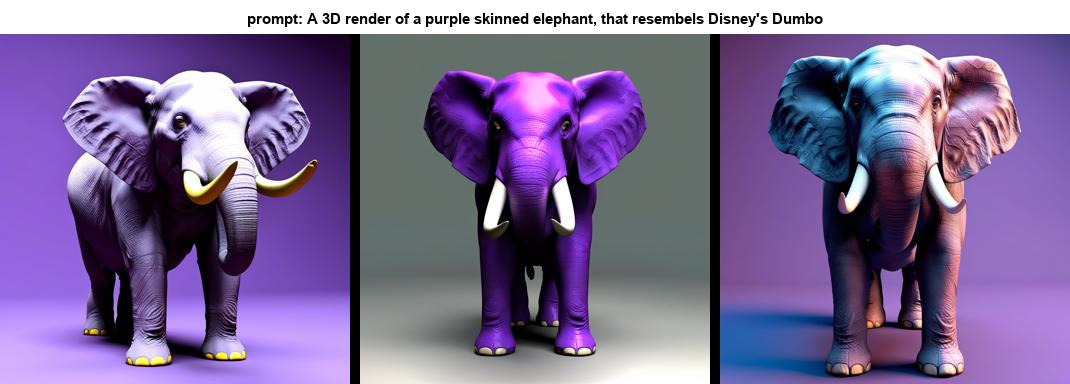

In [6]:
prompt = "A 3D render of a purple skinned elephant, that resembels Disney's Dumbo"
images = text_to_image(prompt)
display_images(images, f"prompt: {prompt}")

When generating the same prompt with Flux we get the following result:

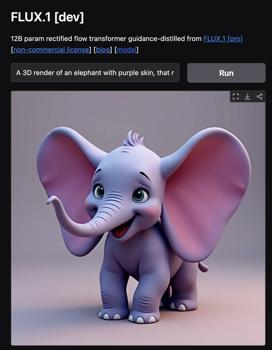

In [7]:
display_images([Image.open("./visuals//flux_dumbo.png")])

### Reproducing The Brand Mascot

We want to enable users to accurately create visuals using their brand assets, such as the following examples of the **Bria Elephant**:

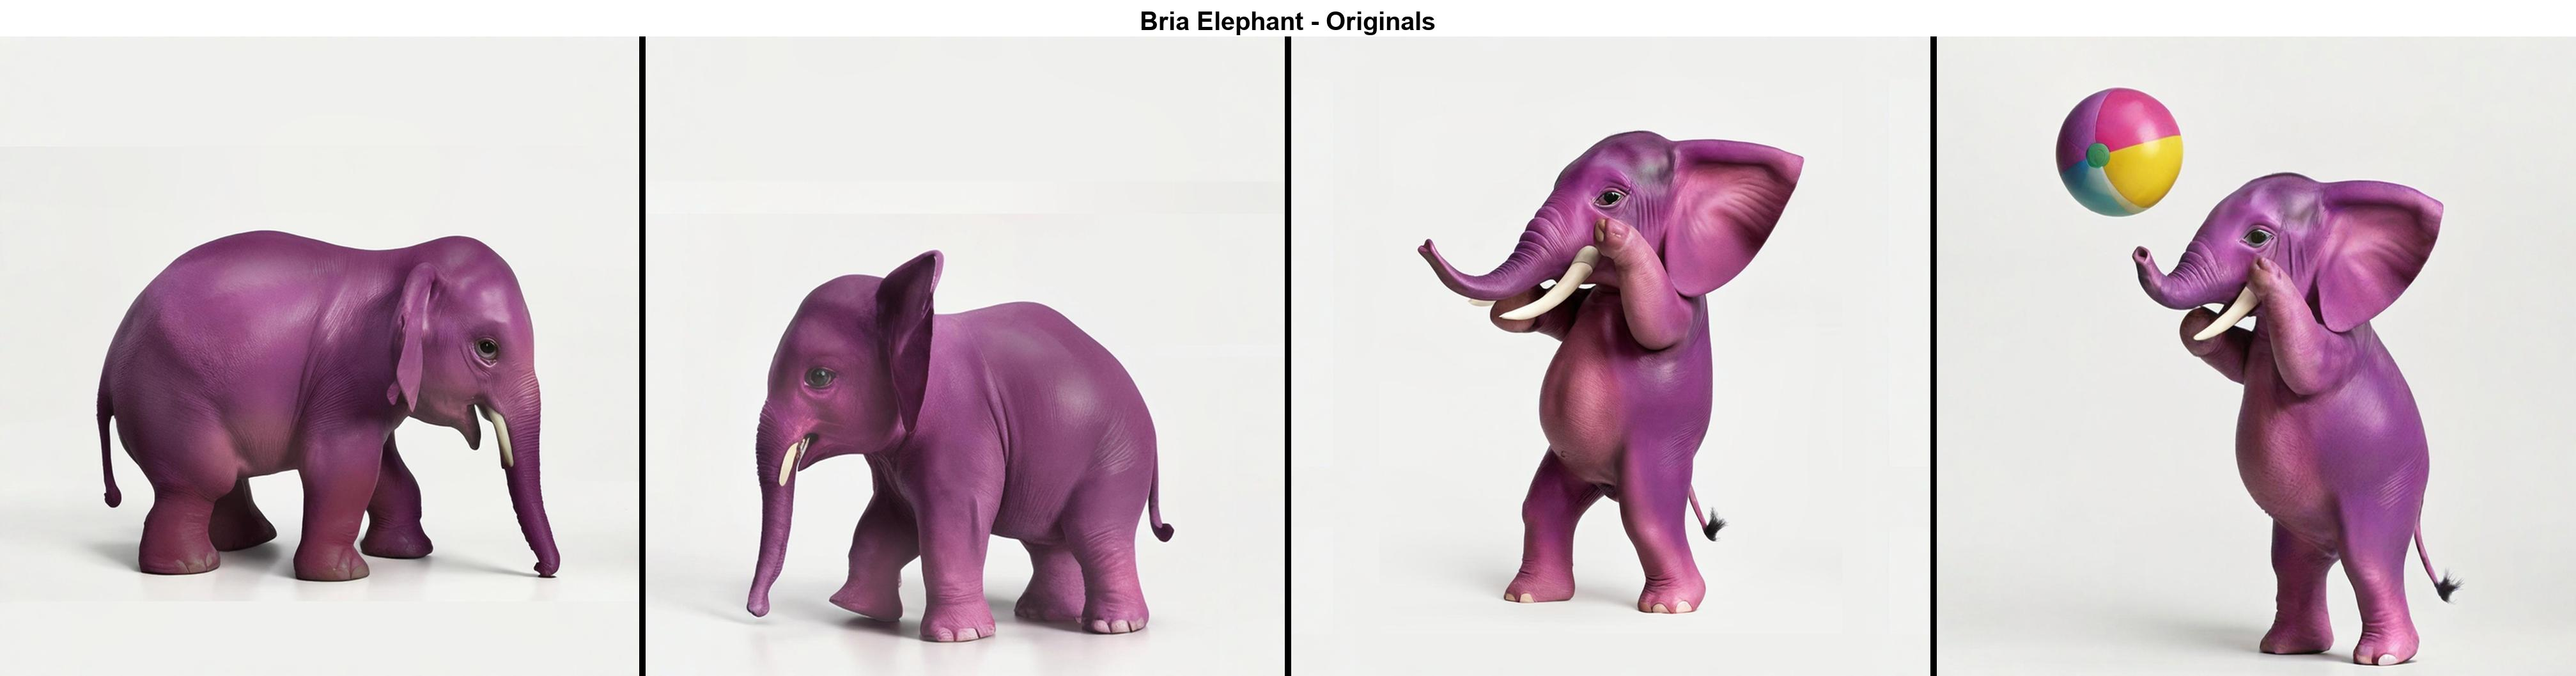

In [8]:
# load sample of bria elephant oiriginal images

bria_bear_dir = "briaphant"
images = [Image.open(f"{bria_bear_dir}/{f}") for f in os.listdir(bria_bear_dir) if "png" in f][:4]
display_images(images, "Bria Elephant - Originals", resize = 1000, font_size=40)

We need to add more components to the text-to-image generation to increase the controlability. We'll start by introducing **Control-Nets**.

## Image Guidance for Controlled Generation
We can add **structural control** using an input image to generate variations of that image, using the following Control Nets which were trained on-top of Bria's foundation text-to-image model:
- Canny
- Depth

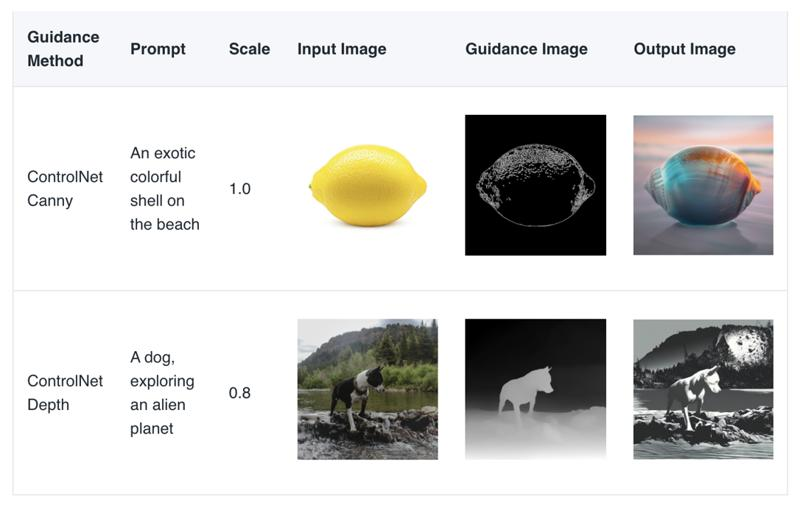

In [9]:
display_images([Image.open("./visuals/control_nets.png")], resize=800)

We'll choose one of the Bria Elephant original images and add structural image guidance to the generation using our trained Control-Nets:

https://huggingface.co/briaai/BRIA-2.3-ControlNet-Canny

https://huggingface.co/briaai/BRIA-2.3-ControlNet-Depth

We'll create a second diffusers pipeline that will integrate the two Control-Nets to reproduce the structure of the input image, while allowing changes through the textual prompt.

(Also available through the text-to-image API as well as the "Reimagine" API: 
https://docs.bria.ai/image-generation/endpoints/reimagine-structure-reference)

In [10]:
import torch
import cv2
import numpy as np
from PIL import Image
from diffusers.utils import load_image
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline


controlnet_canny = ControlNetModel.from_pretrained(
    "briaai/BRIA-2.3-ControlNet-Canny",
    torch_dtype=torch.float16
)


controlnet_depth = ControlNetModel.from_pretrained(
    "briaai/BRIA-2.3-ControlNet-Depth",
    torch_dtype=torch.float16
)
t2i_control_pipe = StableDiffusionXLControlNetPipeline.from_pipe(
                    t2i_pipe,
                    controlnet=[controlnet_canny, controlnet_depth],
                )
t2i_control_pipe.to("cuda")


An error occurred while trying to fetch briaai/BRIA-2.3-ControlNet-Canny: briaai/BRIA-2.3-ControlNet-Canny does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch briaai/BRIA-2.3-ControlNet-Depth: briaai/BRIA-2.3-ControlNet-Depth does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


StableDiffusionXLControlNetPipeline {
  "_class_name": "StableDiffusionXLControlNetPipeline",
  "_diffusers_version": "0.30.2",
  "_name_or_path": "briaai/BRIA-2.3",
  "controlnet": [
    "controlnet",
    "MultiControlNetModel"
  ],
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [11]:
# Function to process image for the canny required input
def get_canny_image(img_path):
    # Calculate Canny image
    input_image = load_image(
        img_path
    )
    input_image = np.array(input_image)
    low_threshold, high_threshold = 100, 200
    input_image = cv2.Canny(input_image, low_threshold, high_threshold)
    input_image = input_image[:, :, None]
    input_image = np.concatenate([input_image, input_image, input_image], axis=2)
    canny_image = Image.fromarray(input_image)
    return canny_image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from torchvision import transforms

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

# Function to process image for the depth required input (depth map)
def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth
    image = transforms.functional.center_crop(image, min(image.shape[-2:]))
    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


def text_to_image_with_guidance(prompt, guidance_image_path, num_results=3, seed=42):
    negative_prompt = "blurry"
    canny_img = get_canny_image(guidance_image_path)
    depth_img = get_depth_map(Image.open(guidance_image_path))

    images = []
    for i in range(num_results):
        generator = torch.Generator(device="cuda:0").manual_seed(seed+i)
        image = t2i_control_pipe(prompt=prompt, negative_prompt=negative_prompt, image=[canny_img, depth_img], controlnet_conditioning_scale=[0.5, 0.5], height=1024, width=1024, generator=generator, num_inference_steps=30).images[0]
        images.append(image)
    return images


/opt/conda/envs/pytorch/lib/python3.11/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

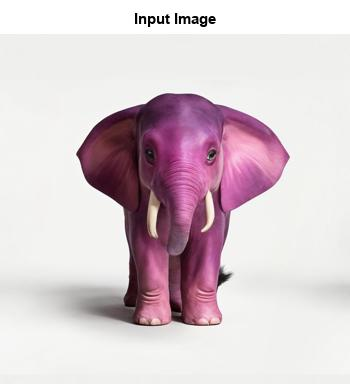

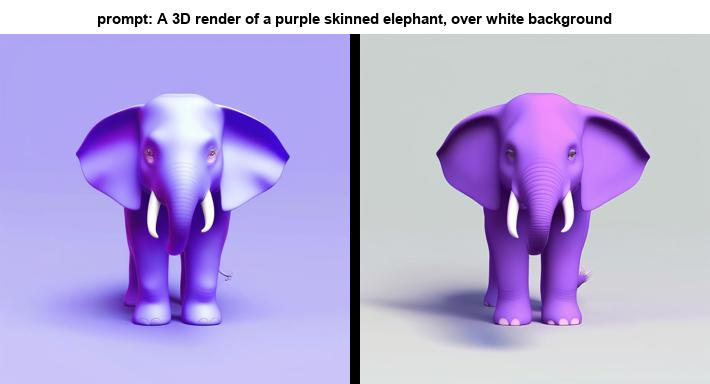

In [12]:
prompt = 'A 3D render of a purple skinned elephant, over white background'
guidance_image_path = "./briaphant/bria_1afcb261_2000_49eb_a908_3656fd9a67fd_4.png"

images = text_to_image_with_guidance(prompt, guidance_image_path, num_results=2)
display_images([Image.open(guidance_image_path)], 'Input Image')
display_images(images, f"prompt: {prompt}")

We can use Control-Nets to change the color of the Bria Elephant:

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

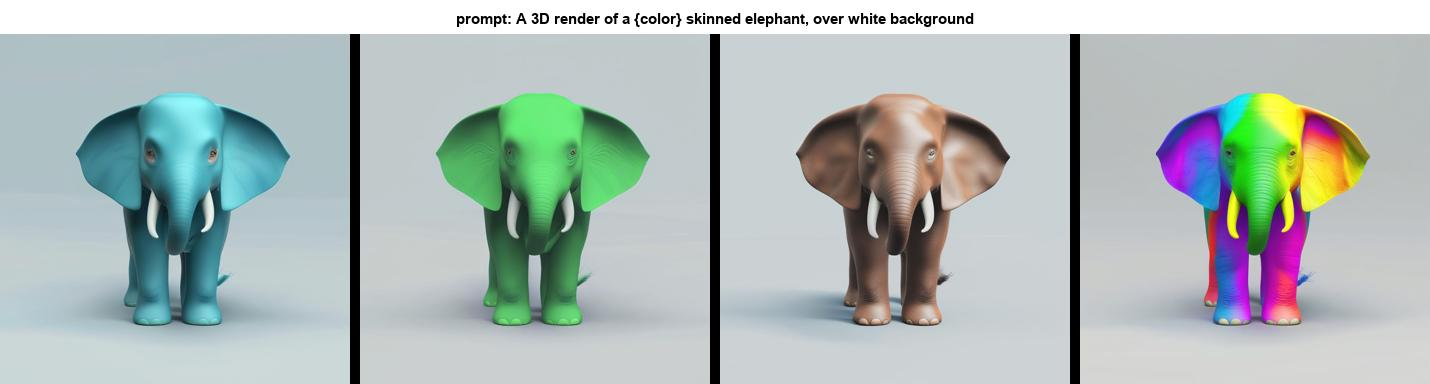

In [13]:
images = []
for color in ['blue', 'green', 'brown', 'rainbow colored']:
    prompt = f'A 3D render of a {color} skinned elephant, over white background'

    image = text_to_image_with_guidance(prompt, guidance_image_path, num_results=1)
    images.append(image[0])
display_images(images, 'prompt: A 3D render of a {color} skinned elephant, over white background')

In some cases this structural control is not enough. We want to enable our users to teach the model to generate a more accurate and varied represenation of this character.

We will allow this by enabling our users to **fine-tune** our foundation model using the original brand images they own.

## Tailored-Generation - Fine-Tuning with LoRA
### Training

We can fine-tune Bria's foundation model using the existing images of the Bria Elephant. For fine-tuning we would use Bria's **4B-Adapt** model, which is designed to provide exceptional fine-tuning capabilities for commercial use: https://huggingface.co/briaai/BRIA-4B-Adapt


We fine-tune using LoRA for easier deployment of each such fine-tuned model. 


Please refer to the following examples:

- Training using Bria's automatic Tailored-Gen API: gtc_demo_fine_tune_api.ipynb

- Training on-prem using Bria's foundation model weights on HF: gtc_demo_fine_tune_on_prem.ipynb

### Inference

Once we finished training and we have the LoRA trained weights available, we can run inference using the HF available weights:

https://huggingface.co/briaai/BRIA-4B-Adapt


(Also available through Bria's API: https://docs.bria.ai/tailored-generation/endpoints/text-to-image-tailored)

In [4]:
# download neccesary python files from HF model card
from huggingface_hub import hf_hub_download
import os

try:
    local_dir = os.path.dirname(__file__)
except:
    local_dir = '.'
    
hf_hub_download(repo_id="briaai/BRIA-4B-Adapt", filename='pipeline_bria.py', local_dir=local_dir)
hf_hub_download(repo_id="briaai/BRIA-4B-Adapt", filename='transformer_bria.py', local_dir=local_dir)
hf_hub_download(repo_id="briaai/BRIA-4B-Adapt", filename='bria_utils.py', local_dir=local_dir)
hf_hub_download(repo_id="briaai/BRIA-4B-Adapt", filename='train_lora.py', local_dir=local_dir)

'train_lora.py'

In [5]:
import torch
from pipeline_bria import BriaPipeline

tailored_pipe = BriaPipeline.from_pretrained("briaai/BRIA-4B-Adapt", torch_dtype=torch.bfloat16,trust_remote_code=True)
tailored_pipe.to(device="cuda")


def tailored_gen(prompt, tailored_model_name, seed=42, lora_scale=1.0):
    
    negative_prompt = "Logo,Watermark,Text,Ugly,Morbid,Extra fingers,Poorly drawn hands,Mutation,Blurry,Extra limbs,Gross proportions,Missing arms,Mutated hands,Long neck,Duplicate,Mutilated,Mutilated hands,Poorly drawn face,Deformed,Bad anatomy,Cloned face,Malformed limbs,Missing legs,Too many fingers"

    tailored_pipe.load_lora_weights("briaai/BRIA-4B-Adapt", subfolder="example_finetuned_model", weight_name = f"{tailored_model_name}.safetensors")
    generator = torch.Generator("cuda").manual_seed(seed)
    image = tailored_pipe(prompt=prompt, negative_prompt=negative_prompt, height=1024, width=1024, generator=generator, joint_attention_kwargs={"scale": lora_scale}, num_inference_steps=30).images[0]
    return image

Keyword arguments {'trust_remote_code': True} are not expected by BriaPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

We fine-tuned using image captions that share the same prefix, which we'll use for the inference prompt as well:

  0%|          | 0/30 [00:00<?, ?it/s]

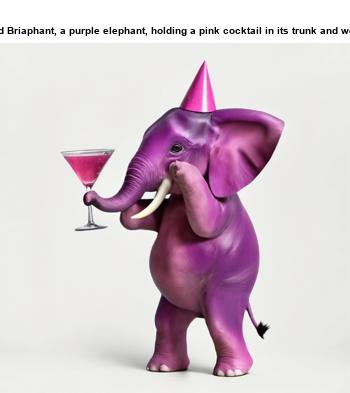

In [16]:
prompt = "A photo of a character named Briaphant, a purple elephant, holding a pink cocktail in its trunk and wearing a small pink party hat"
tailored_model_name = "bria_elephant"

elephant_image = tailored_gen(prompt, tailored_model_name)
elephant_image.save('./on_prem_results/elephant_image.jpg')
display_images([elephant_image], f"prompt: \n{prompt}", font_size=10)

Great. Now let's place this festive character in a proper location by generating on-brand backgrounds.

We want the background to adhere to the brand style as well, so we'll use a tailored model trained on the following brand style images:

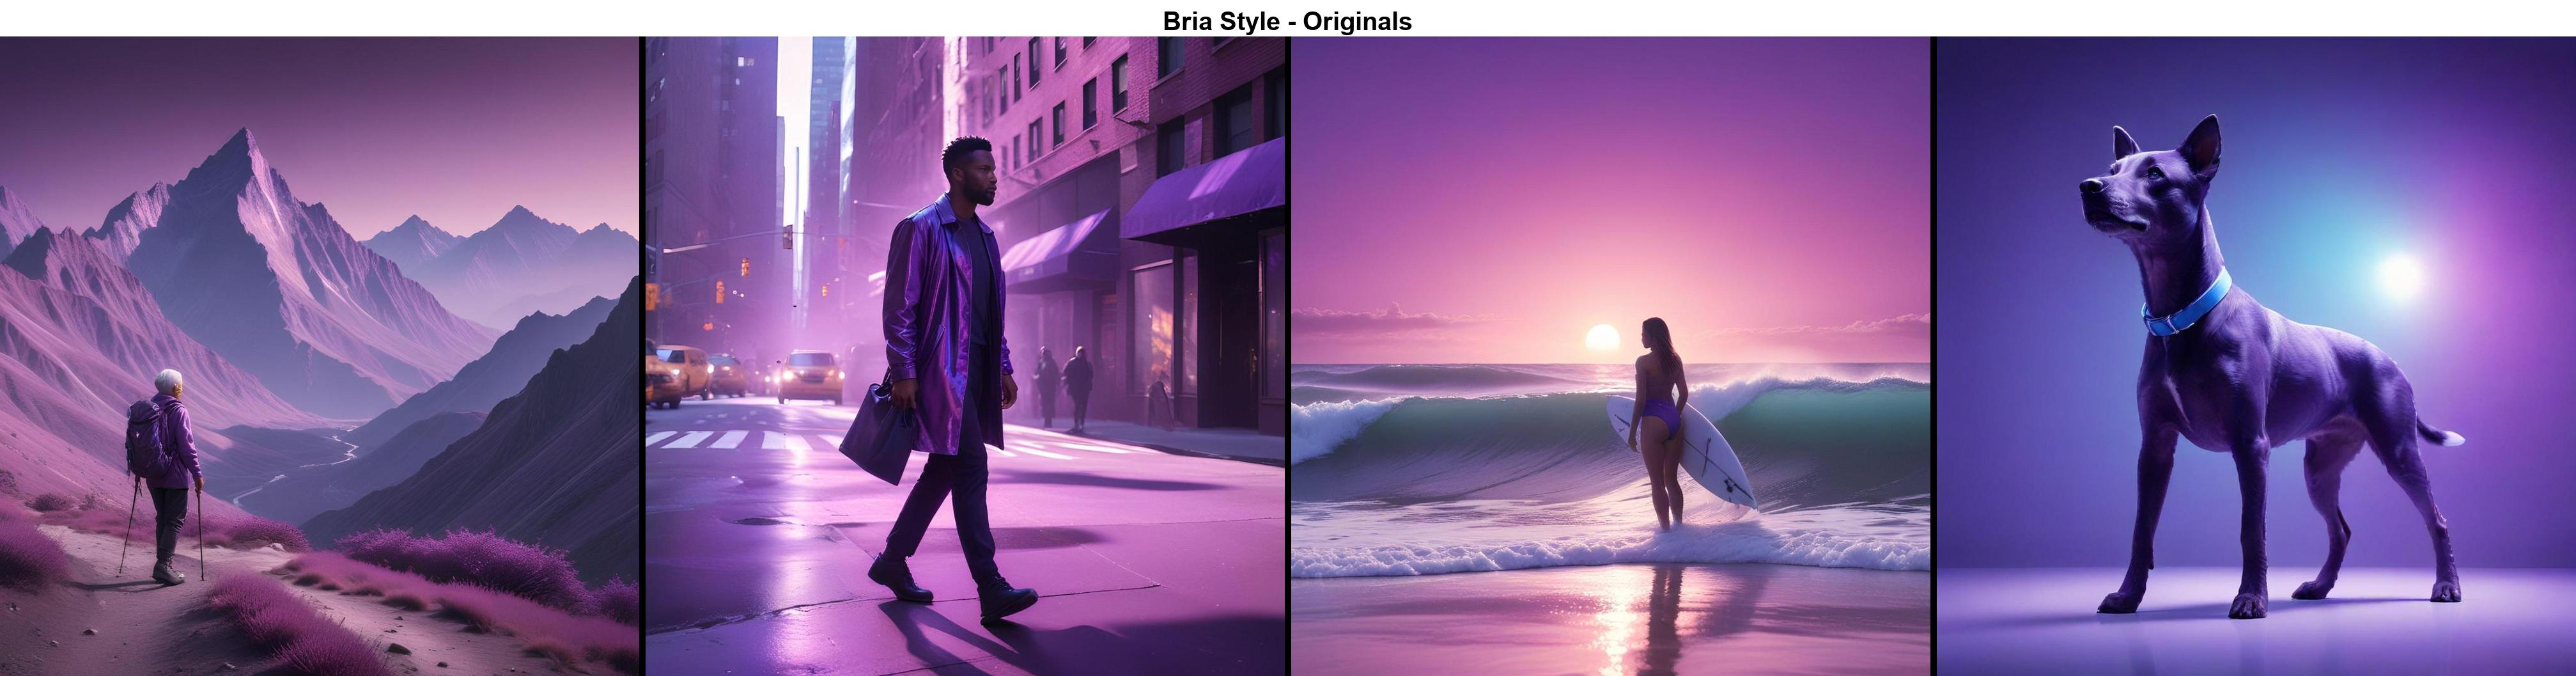

In [17]:
# load sample of bria style oiriginal images
bria_style_dir = "bria_style"

images = [Image.open(f"{bria_style_dir}/{f}") for f in os.listdir(bria_style_dir)][:4]
display_images(images, "Bria Style - Originals", resize = 1000, font_size=40)

We used an LLM to write a few prompts for background images that could be relevant for this character in a festive event. 

Let's generate 1 example from each, using the brand style tailored model.

In [14]:
background_prompts = [
 'A tropical beach at sunset with palm trees, soft waves, and string lights, perfect for a relaxing party vibe',
 'A winter wonderland party with twinkling snowflakes, icy-blue lighting, and festive holiday purple decorations creating a cozy atmosphere',
 'A cosmic galaxy party with glowing planets, swirling nebulas, and a dance floor that looks like the surface of the moon.',
 'A lively party venue with colorful decorations, balloons, streamers, and warm lighting, creating a fun and festive atmosphere',
 'A carnival-themed party with bright lights, a Ferris wheel in the background, colorful booths, and festive decorations',
 'A futuristic space party with floating balloons, glowing neon decorations, and a starry galaxy sky in the background',
 "A retro '80s party with neon colors, arcade machines, a checkered dance floor, and a boombox playing classic hits.",
 'A jungle adventure party with tropical foliage, tiki torches, tribal drums, and exotic animals hidden in the background.',
 'A rooftop sunset cocktail party with stylish lounge seating, golden hour lighting, and a panoramic city skyline view.'
 ]

bg_originals_dir = "./on_prem_results/bg_gen/bg_originals"

In [19]:
# generate style backgrounds
os.makedirs(bg_originals_dir, exist_ok=True)

all_bg_images = []
for i, prompt in enumerate(background_prompts):
    tailored_model_name = "bria_style"
    bg_image = tailored_gen(prompt, tailored_model_name)
    bg_image.save(f'{bg_originals_dir}/{i}.png')
    all_bg_images.append(bg_image)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

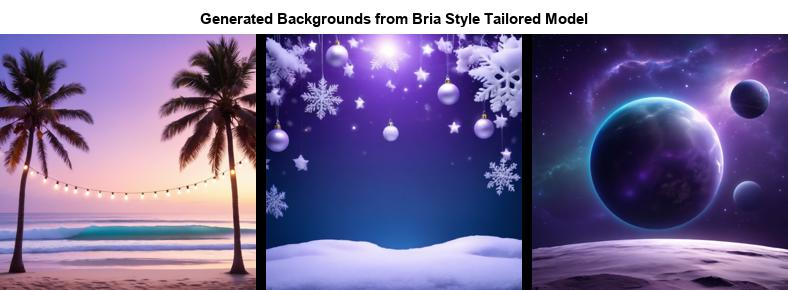

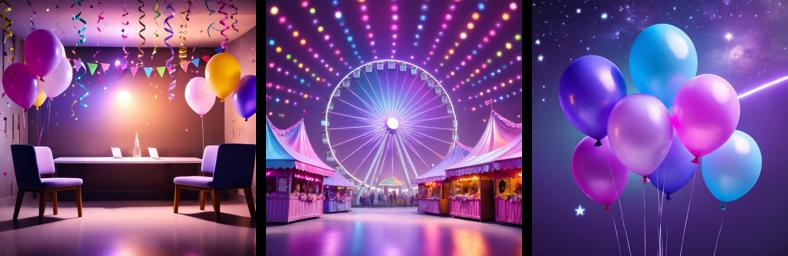

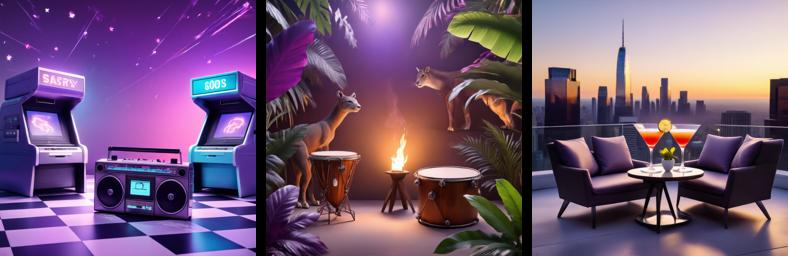

In [20]:
# display results
all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]
display_images(all_bg_images[:3], f"Generated Backgrounds from Bria Style Tailored Model", resize = 256)
display_images(all_bg_images[3:6], resize = 256)
display_images(all_bg_images[6:9], resize = 256)

## Background Genreation (by Reference Image)



Next, we want to use those on-brand backgrounds we created as inspiration for new background that will include our festive Bria Elephant. 

We'll use a special Control-Net trained to generate backgrounds around a given foreground (in this case: the elephant image): https://huggingface.co/briaai/BRIA-2.3-ControlNet-BG-Gen

To use the generated backgrounds as inspiration, we'll add Image-Prompt Adapter (IP-Adapter) to the pipeline, which will enable prompting with a given image instead of a textual description: https://huggingface.co/briaai/Image-Prompt



(Also available throught Bria's API: https://docs.bria.ai/image-editing/endpoints/background-replace)

In [21]:
# Download neccesary python files from HF model card
! huggingface-cli download briaai/BRIA-2.3-ControlNet-BG-Gen --include replace_bg/* --local-dir . --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/ubuntu/GTC25_Demo


In [6]:
# empty cuda cache
try:
    del tailored_pipe
    torch.cuda.empty_cache()
except:
    pass

from diffusers import (
    AutoencoderKL,
    EulerAncestralDiscreteScheduler,
)
from diffusers.utils import load_image
from replace_bg.model.pipeline_controlnet_sd_xl import StableDiffusionXLControlNetPipeline
from replace_bg.model.controlnet import ControlNetModel
from replace_bg.utilities import resize_image, remove_bg_from_image, paste_fg_over_image, get_control_image_tensor

controlnet = ControlNetModel.from_pretrained("briaai/BRIA-2.3-ControlNet-BG-Gen", torch_dtype=torch.float16) 
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
scheduler = EulerAncestralDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    steps_offset=1
)
replace_bg_pipe = StableDiffusionXLControlNetPipeline.from_pipe(
                    t2i_pipe,
                    vae=vae,
                    controlnet=controlnet,
                    scheduler=scheduler,
                )
replace_bg_pipe.load_ip_adapter("briaai/Image-Prompt", subfolder='models', weight_name="ip_adapter_bria.bin")

replace_bg_pipe.to("cuda")

StableDiffusionXLControlNetPipeline {
  "_class_name": "StableDiffusionXLControlNetPipeline",
  "_diffusers_version": "0.30.2",
  "_name_or_path": "briaai/BRIA-2.3",
  "controlnet": [
    "replace_bg.model.controlnet",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [23]:
def pad_image(image, padding_values):
    orig_image = image
    old_size = orig_image.size

    padding = padding_values
    new_size = (old_size[0]+padding[0]+padding[1], old_size[1]+padding[2]+padding[3])
    paste_loc = (padding[0], padding[2])
    new_image = Image.new("RGB", new_size, (255,255,255))
    new_image.paste(orig_image, paste_loc)
    return new_image

def generate_bg_by_image(foreground_image_path, bg_image, seed=42, prompt="high quality"):

    image = load_image(foreground_image_path)
    image = resize_image(image)
    mask = remove_bg_from_image(foreground_image_path)
    control_tensor = get_control_image_tensor(replace_bg_pipe.vae, image, mask)

    negative_prompt = "Logo,Watermark,Text,Ugly,Bad proportions,Bad quality,Out of frame,Mutation"
    generator = torch.Generator(device="cuda:0").manual_seed(seed)

    gen_img = replace_bg_pipe(
        ip_adapter_image=bg_image.resize((224, 224)),
        negative_prompt=negative_prompt, 
        prompt=prompt,     
        controlnet_conditioning_scale=1.0, 
        num_inference_steps=30,
        image = control_tensor,
        generator=generator,
        guidance_scale=5
    ).images[0]

    result_image = paste_fg_over_image(gen_img, image, mask)
    return result_image


In [24]:
bg_generations_dir = "./on_prem_results/bg_gen/bg_generations"

In [25]:
# generate backgrounds for elephant
os.makedirs(bg_generations_dir, exist_ok=True)

all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]

foreground_image = Image.open('./on_prem_results/elephant_image.jpg')

resize_scale = 0.25 # we'll make the elephant 25% smaller to fit into the background images
# we want the elephant to be positioned in the bottom right corner of the background image, so we'll add padding accordingly
width_padding = int(foreground_image.size[0]*resize_scale)
height_padding = int(foreground_image.size[1]*resize_scale)
bottom_right_location = [width_padding, 0, height_padding, 0]

foreground_image_padded = pad_image(foreground_image, bottom_right_location)
foreground_image_path = './on_prem_results/elephant_image_padded.jpg'
foreground_image_padded.save(foreground_image_path)

all_images = []
for i, bg_img in enumerate(all_bg_images):
    
    new_bg_img = generate_bg_by_image(foreground_image_path, bg_img, prompt = background_prompts[i])
    new_bg_img.save(f'{bg_generations_dir}/{i}.png')
    all_images.append(new_bg_img)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


  0%|          | 0/30 [00:00<?, ?it/s]

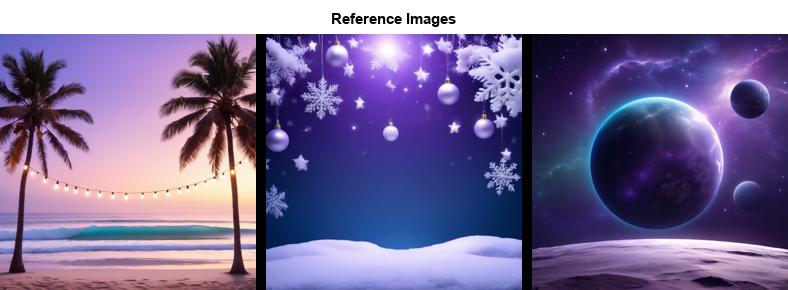

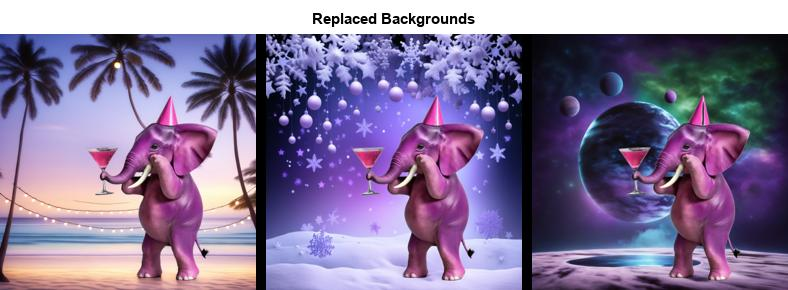

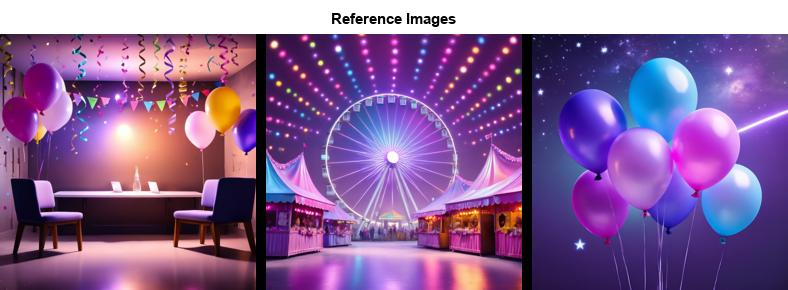

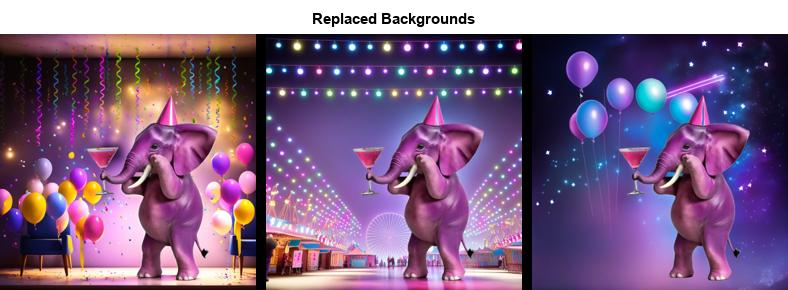

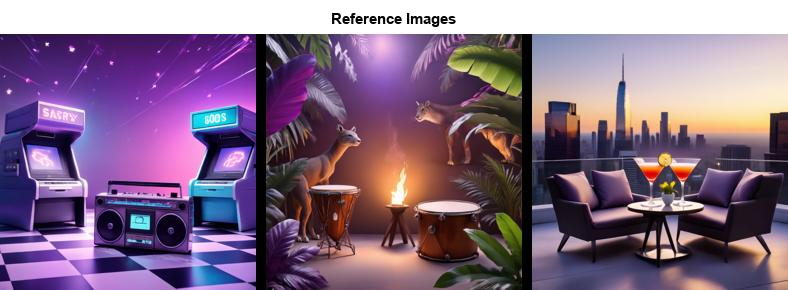

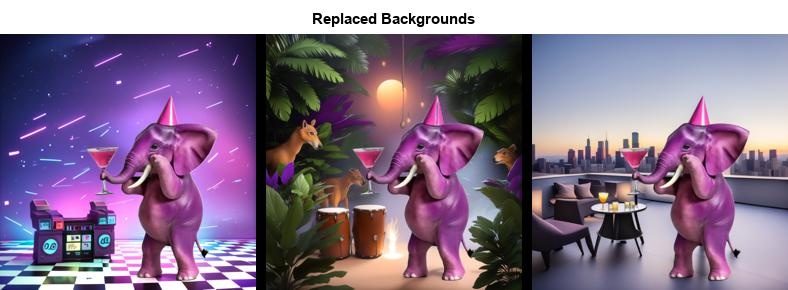

In [26]:
# display results
all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]
all_images = [Image.open(f'{bg_generations_dir}/{i}.png') for i in range(len(background_prompts))]
display_images(all_bg_images[:3], f"Reference Images", resize = 256)
display_images(all_images[:3],  f"Replaced Backgrounds", resize = 256)
print('\n')
display_images(all_bg_images[3:6],  f"Reference Images", resize = 256)
display_images(all_images[3:6], f"Replaced Backgrounds", resize = 256)
print('\n')
display_images(all_bg_images[6:9],  f"Reference Images", resize = 256)
display_images(all_images[6:9], f"Replaced Backgrounds", resize = 256)

## Image Editing: Generative Fill


Focusing on the first 3 outputs, let's fix some content issues by replacing or adding objects.

We'll be using Bria's Generative-Fill Control-Net, which enables to add or modify certain areas in the image, given a mask: https://huggingface.co/briaai/BRIA-2.3-ControlNet-Generative-Fill

(Also available through Bria's API: https://docs.bria.ai/image-editing/endpoints/gen-fill)

In [7]:
try:
    controlnet_canny.to('cpu')
    controlnet_depth.to('cpu')
    torch.cuda.empty_cache()
except:
    pass
    
from replace_bg.model.pipeline_controlnet_sd_xl import StableDiffusionXLControlNetPipeline
from replace_bg.model.controlnet import ControlNetModel, ControlNetConditioningEmbedding

from torchvision import transforms

def resize_image_to_retain_ratio(image):
    pixel_number = 1024*1024
    granularity_val = 8
    ratio = image.size[0] / image.size[1]
    width = int((pixel_number * ratio) ** 0.5)
    width = width - (width % granularity_val)
    height = int(pixel_number / width)
    height = height - (height % granularity_val)

    image = image.resize((width, height))
    return image

def get_masked_image(image, image_mask, width, height):
    image_mask = image_mask # fill area is white
    image_mask = image_mask.resize((width, height)) # object to remove is white (1)
    image_mask_pil = image_mask
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask_pil.convert("L")).astype(np.float32) / 255.0
    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    masked_image_to_present = image.copy()
    masked_image_to_present[image_mask > 0.5] = (0.5,0.5,0.5)  # set as masked pixel
    image[image_mask > 0.5] = 0.5  # set as masked pixel - s.t. will be grey 
    image = Image.fromarray((image * 255.0).astype(np.uint8))
    masked_image_to_present = Image.fromarray((masked_image_to_present * 255.0).astype(np.uint8))
    return image, image_mask_pil, masked_image_to_present


image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
# Load, init model    
controlnet = ControlNetModel().from_pretrained("briaai/BRIA-2.3-ControlNet-Generative-Fill", torch_dtype=torch.float16)

gen_fill_pipe = StableDiffusionXLControlNetPipeline.from_pipe(
                    replace_bg_pipe,
                    controlnet=controlnet,
                )

vae = gen_fill_pipe.vae

gen_fill_pipe.unload_ip_adapter()
gen_fill_pipe = gen_fill_pipe.to(device="cuda", torch_dtype=torch.float16)

An error occurred while trying to fetch briaai/BRIA-2.3-ControlNet-Generative-Fill: briaai/BRIA-2.3-ControlNet-Generative-Fill does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [8]:
def gen_fill(input_img, mask, prompt, seed=42):

    default_negative_prompt = "blurry"

    init_image = input_img.resize((1024, 1024))
    mask_image = mask.resize((1024, 1024))


    init_image = resize_image_to_retain_ratio(init_image)
    width, height = init_image.size

    mask_image = mask_image.convert("L").resize(init_image.size)

    width, height = init_image.size

    masked_image, image_mask, masked_image_to_present = get_masked_image(init_image, mask_image, width, height)

    masked_image_tensor = image_transforms(masked_image)
    masked_image_tensor = (masked_image_tensor - 0.5) / 0.5

    masked_image_tensor = masked_image_tensor.unsqueeze(0).to(device="cuda")
    control_latents = vae.encode(  
            masked_image_tensor[:, :3, :, :].to(vae.dtype)
        ).latent_dist.sample()   
    control_latents = control_latents * vae.config.scaling_factor 


    image_mask = np.array(image_mask)[:,:]
    mask_tensor = torch.tensor(image_mask, dtype=torch.float32)[None, ...]
    # binarize the mask
    mask_tensor = torch.where(mask_tensor > 128.0, 255.0, 0)       

    mask_tensor = mask_tensor / 255.0

    mask_tensor = mask_tensor.to(device="cuda")
    mask_resized = torch.nn.functional.interpolate(mask_tensor[None, ...], size=(control_latents.shape[2], control_latents.shape[3]), mode='nearest')

    masked_image = torch.cat([control_latents, mask_resized], dim=1)

    generator = torch.Generator(device="cuda").manual_seed(seed)
    
    gen_img = gen_fill_pipe(negative_prompt=default_negative_prompt, prompt=prompt, 
            controlnet_conditioning_scale=1.0, 
            num_inference_steps=20, 
            height=height, width=width, 
            image = masked_image,
            init_image = init_image,     
            mask_image = mask_tensor,
            guidance_scale = 3,
            generator=generator).images[0]

    return gen_img

The first image is a beach scene, let's replace the party hat with some beachwear. We'll use a mask around the hat we want to replace, and specifiy the new content in "prompt":

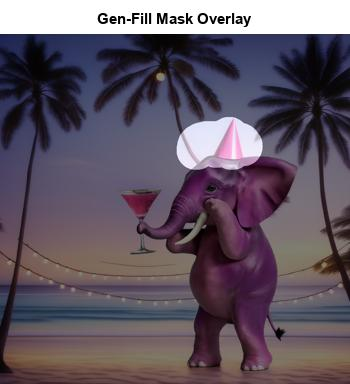

  0%|          | 0/20 [00:00<?, ?it/s]

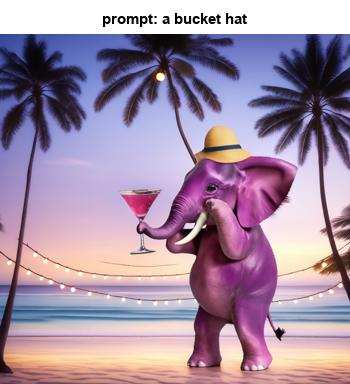

In [29]:
input_image = Image.open(f'./on_prem_results/bg_gen/bg_generations/0.png')
mask = Image.open('./on_prem_results/masks/hat_mask.png')
prompt = "a bucket hat"

display_mask(mask, input_image)

output_var1 = gen_fill(input_image, mask, prompt)
output_var1.save(f'./on_prem_results/bg_gen/bg_generations/0_fixed.png')
display_images([output_var1], f"prompt: {prompt}")

Now let's replace the hat in the second image to something more suitable for winter festivities:

  0%|          | 0/20 [00:00<?, ?it/s]

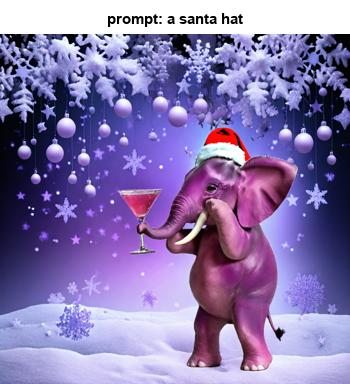

In [40]:
input_image = Image.open(f'./on_prem_results/bg_gen/bg_generations/1.png')
mask = Image.open('./on_prem_results/masks/hat_mask.png')
prompt = "a santa hat"

output_var2 = gen_fill(input_image, mask, prompt)
output_var2.save(f'./on_prem_results/bg_gen/bg_generations/1_fixed.png')
display_images([output_var2], f"prompt: {prompt}")

We can also add a christmas tree in the brand colors

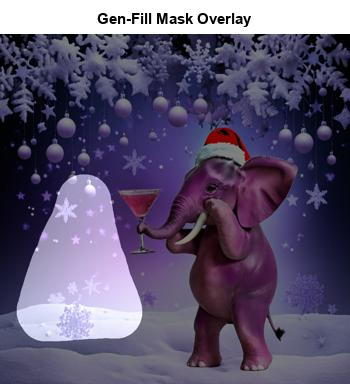

  0%|          | 0/20 [00:00<?, ?it/s]

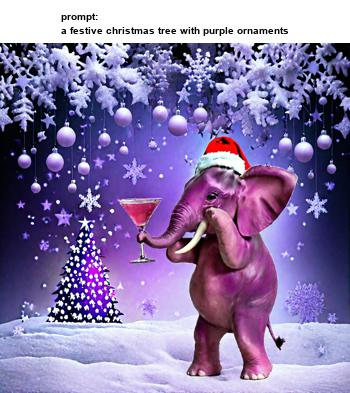

In [41]:
input_image = Image.open(f'./on_prem_results/bg_gen/bg_generations/1_fixed.png')
mask = Image.open('./on_prem_results/masks/tree_mask.png')
prompt = "a festive christmas tree with purple ornaments"

display_mask(mask, input_image)
output_var2 = gen_fill(input_image, mask, prompt)
output_var2.save(f'./on_prem_results/bg_gen/bg_generations/1_fixed.png')
display_images([output_var2], f"prompt: \n{prompt}", font_size=10)

## Image Editing: Expand

We now have our 3 image varaiations ready. But what if we wanted to use them in adds with different aspect ratios? 

We'll be using Bria's Inpainting Control-Net to extend the image beyond the current square canvas: https://huggingface.co/briaai/BRIA-2.3-ControlNet-Inpainting

(Also available through Bria's API: https://docs.bria.ai/image-editing/endpoints/image-expansion)

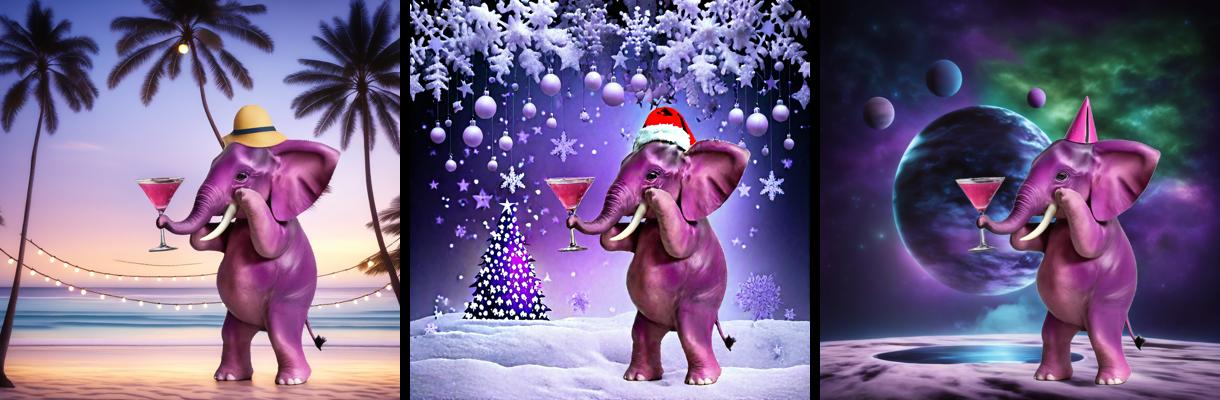

In [2]:
output_var1 = Image.open(f'./on_prem_results/bg_gen/bg_generations/0_fixed.png')
output_var2 = Image.open(f'./on_prem_results/bg_gen/bg_generations/1_fixed.png')
output_var3 = Image.open(f'./on_prem_results/bg_gen/bg_generations/2.png')
image_variations = [output_var1, output_var2, output_var3]
display_images(image_variations, resize = 400)

In [9]:
# create expand image pipeline
from diffusers import LCMScheduler

controlnet = ControlNetModel().from_pretrained("briaai/BRIA-2.3-ControlNet-Inpainting", torch_dtype=torch.float16)

expand_pipe = StableDiffusionXLControlNetPipeline.from_pipe(
                    gen_fill_pipe,
                    controlnet=controlnet,
                )

expand_pipe = expand_pipe.to(device="cuda", torch_dtype=torch.float16)

expand_pipe.scheduler = LCMScheduler.from_config(expand_pipe.scheduler.config)
expand_pipe.load_lora_weights("briaai/BRIA-2.3-FAST-LORA")
# expand_pipe.fuse_lora()
expand_pipe = expand_pipe.to(device="cuda")
vae = expand_pipe.vae

An error occurred while trying to fetch briaai/BRIA-2.3-ControlNet-Inpainting: briaai/BRIA-2.3-ControlNet-Inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [21]:
def get_masked_image_inpainting_area_in_gray(image, image_mask):
    image = np.array(image, dtype=np.float32) / 255.0
    image_mask = np.array(image_mask, dtype=np.float32) / 255.0
    image[image_mask > 0.5] = 0.5  # set as masked pixel - s.t. will be grey 
    
    return Image.fromarray(np.array(image * 255.0, dtype=np.uint8))

def expand_image(init_image, prompt, canvas_size, image_location, seed = 100):
    default_negative_prompt = "blurry"
    
    image_size = init_image.size
    original_image_width, original_image_height = image_size

    init_image = init_image.resize(image_size, resample=Image.Resampling.LANCZOS)
    # Create an empty canvas with a transparent background
    canvas = Image.new('RGB', canvas_size, (255, 255, 255))
    # Paste the original image onto the canvas at the desired location
    canvas.paste(init_image, image_location)

    # Create a white mask canvas
    mask_image = Image.new('L', canvas_size, 255)  # 'L' mode for grayscale

    # Create a black rectangle where the image will be pasted
    paste_box = (image_location[0], image_location[1],
                image_location[0] + original_image_width,
                image_location[1] + original_image_height)

    # Draw the black rectangle onto the mask
    mask_image.paste(0, paste_box)
    masked_image = get_masked_image_inpainting_area_in_gray(canvas, mask_image)
    width, height = masked_image.size

    generator = torch.Generator(device="cuda").manual_seed(seed)

    masked_image_tensor = image_transforms(masked_image)
    masked_image_tensor = (masked_image_tensor - 0.5) / 0.5

    masked_image_tensor = masked_image_tensor.unsqueeze(0).to(device="cuda")
    with torch.no_grad():
        control_latents = vae.encode(  
            masked_image_tensor[:, :3, :, :].to(vae.dtype)
        ).latent_dist.sample()   
    control_latents = control_latents * vae.config.scaling_factor 

    image_mask = np.array(mask_image)[:,:]
    mask_tensor = torch.tensor(image_mask, dtype=torch.float32)[None, ...]
    # binarize the mask
    mask_tensor = torch.where(mask_tensor >= 128.0, 255.0, 0)       

    mask_tensor = mask_tensor / 255.0

    mask_tensor = mask_tensor.to(device="cuda")
    mask_resized = torch.nn.functional.interpolate(mask_tensor[None, ...], size=(control_latents.shape[2], control_latents.shape[3]), mode='nearest')

    masked_image = torch.cat([control_latents, mask_resized], dim=1)

    gen_img = expand_pipe(negative_prompt=default_negative_prompt,
                    prompt=prompt, 
                controlnet_conditioning_scale=1.0, 
                num_inference_steps=15, 
                height=height, width=width, 
                image = masked_image, # control image
                mask_image = mask_tensor,
                guidance_scale = 1.2,
                generator=generator).images[0]
    return gen_img

In [22]:
output_var1 = Image.open(f'./on_prem_results/bg_gen/bg_generations/0_fixed.png')
output_var2 = Image.open(f'./on_prem_results/bg_gen/bg_generations/1_fixed.png')
output_var3 = Image.open(f'./on_prem_results/bg_gen/bg_generations/2.png')
image_variations = [output_var1, output_var2, output_var3]

# expend top
expanded_images_top = []
for i, image_var in enumerate(image_variations):
        width, height = image_var.size
        image_location = (0, height)
        canvas_size = (width,
                height*2)

        exp_img = expand_image(image_var, background_prompts[i], canvas_size, image_location)
        exp_img.save(f'./on_prem_results/bg_gen/bg_generations/{i}_exp_top.png')
        expanded_images_top.append(exp_img)



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
# expend left
expanded_images_left = []
for i, image_var in enumerate(image_variations):
        width, height = image_var.size
        image_location = (width, 0)
        canvas_size = (width*2,
                height)

        exp_img = expand_image(image_var, background_prompts[i], canvas_size, image_location)
        exp_img.save(f'./on_prem_results/bg_gen/bg_generations/{i}_exp_left.png')
        expanded_images_left.append(exp_img)



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

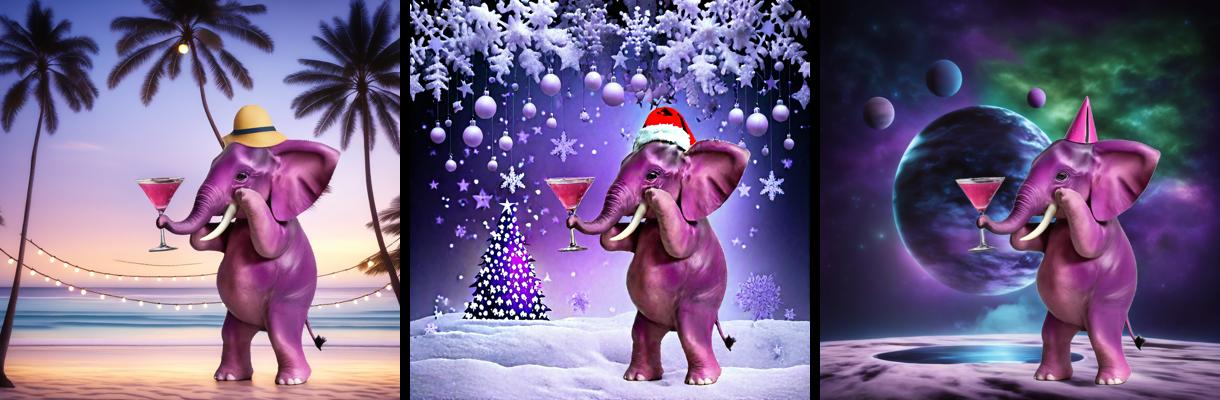

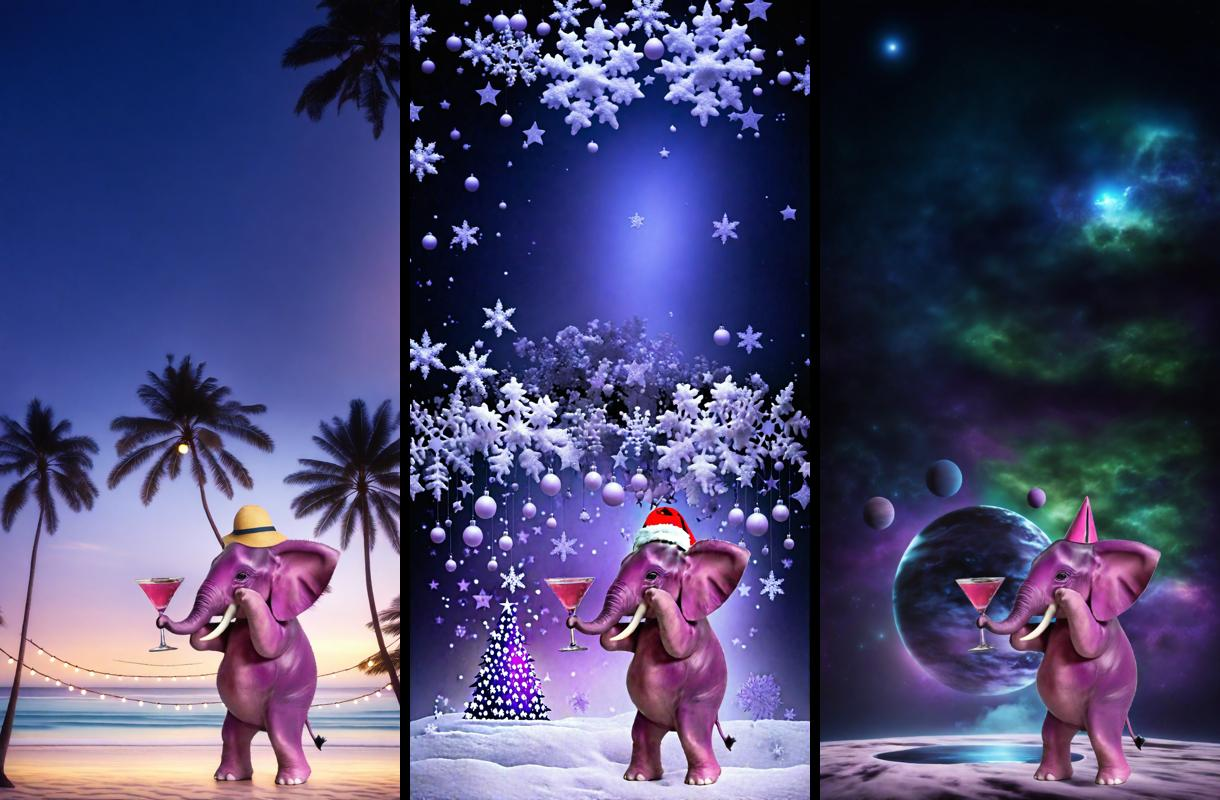

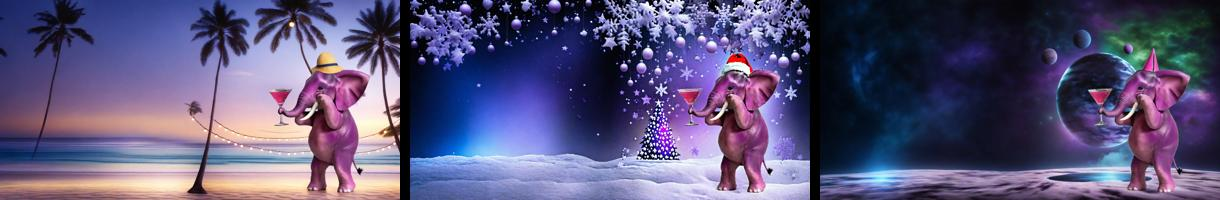

In [24]:
display_images(image_variations, resize = 400)
display_images(expanded_images_top, resize = 800)
display_images(expanded_images_left, resize = 400)

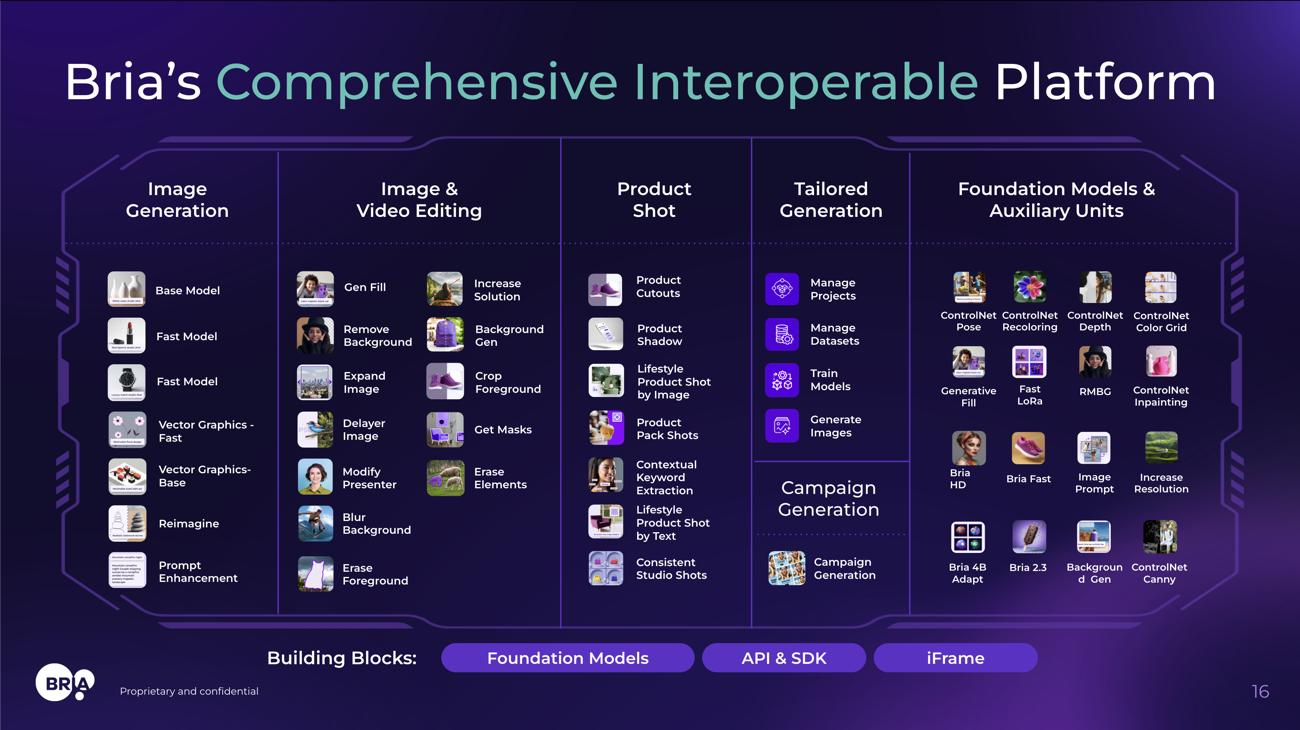

In [20]:
display_images([Image.open("./visuals/bria_intro2.png")], resize = 1300)

GitHub Demo Repo:

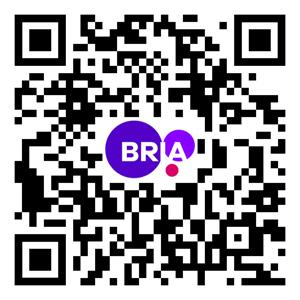

In [39]:
display_images([Image.open("./visuals/qr_code.png")], resize=300)